In [1]:
DATE = "2021-08-25"
TASK = "annealing-correction"
DIR = mkpath("$(homedir())/$(DATE)-$(TASK)")

"/home/jovyan/2021-08-25-annealing-correction"

In [2]:
import Pkg
pkgs = [
#     "BioAlignments",
    "BioSequences",
    "Clustering",
#     "CodecZlib",
#     "Colors",
#     "Combinatorics",
    "DataFrames",
    "DataStructures",
    "Dates",
#     "DelimitedFiles",
    "Distances",
#     "EzXML",
    "FASTX",
#     "GFF3",
#     "HTTP",
#     "Impute",
#     "JSON",
    "Graphs",
    "LSHFunctions",
#     "Measures",
    "MetaGraphs",
    "https://github.com/cjprybol/Mycelia.git",
#     "NumericIO",
#     "PlotlyJS",
#     "Plots",
    "Primes",
#     "Printf",
    "ProgressMeter",
    "Random",
    "Revise",
    "SparseArrays",
    "Statistics",
    "StatsBase",
    "StatsPlots",
#     "StringDistances",
    "uCSV",
#     "XLSX",
]

unregistered_packages = filter(pkg -> occursin(r"(^https|git$)", pkg), pkgs)
registered_packages = setdiff(pkgs, unregistered_packages)

for pkg in registered_packages
    try
        eval(Meta.parse("import $(pkg)"))
    catch
        Pkg.add(pkg)
        Pkg.build(pkg)
        eval(Meta.parse("import $(pkg)"))
    end
end

for pkg_url in unregistered_packages
    pkg_name = replace(basename(pkg_url), ".git" => "")
    try
        eval(Meta.parse("import $(pkg_name)"))
    catch
        Pkg.develop(url=pkg_url)
        Pkg.build(pkg_name)
        eval(Meta.parse("import $(pkg_name)"))
    end
end

In [3]:
if Sys.isapple()
    BANDAGE = "/Applications/Bandage.app/Contents/MacOS/Bandage"
else
    BANDAGE = "Bandage"
end

"Bandage"

In [4]:
function assess_kmer_sparsity_in_reads(k, observations)
    canonical_kmer_counts = Mycelia.count_canonical_kmers(BioSequences.DNAMer{k}, observations)
    total_observed_canonical_kmers = length(keys(canonical_kmer_counts))
    total_possible_canonical_kmers = (4^k)/2
    sparsity = round(total_observed_canonical_kmers/total_possible_canonical_kmers*100, sigdigits=3)
    return sparsity
end

assess_kmer_sparsity_in_reads (generic function with 1 method)

In [5]:
function sequence_to_canonical_kmers(kmer_type, sequence)
    return (BioSequences.canonical(kmer.fw) for kmer in BioSequences.each(kmer_type, sequence))
end

sequence_to_canonical_kmers (generic function with 1 method)

In [6]:
function determine_edge_weights(graph)
    outgoing_edge_probabilities = determine_edge_weights(graph, true)
    incoming_edge_probabilities = determine_edge_weights(graph, false)
    return Dict(true => outgoing_edge_probabilities, false => incoming_edge_probabilities)
end

determine_edge_weights (generic function with 1 method)

In [7]:
function determine_edge_weights(graph, strand)
    kmers = [graph.vprops[v][:kmer] for v in Graphs.vertices(graph)]
    outgoing_edge_weights = SparseArrays.spzeros(length(kmers), length(kmers))
    
    for (kmer_index, kmer) in enumerate(kmers)
        if !strand
            kmer = BioSequences.reverse_complement(kmer)
        end
        
        downstream_neighbors = []
        downstream_neighbor_weights = []
        for neighbor in BioSequences.neighbors(kmer)
            canonical_neighbor = BioSequences.canonical(neighbor)
            neighbor_orientation = neighbor == canonical_neighbor
            
            neighbor_index_range = searchsorted(kmers, canonical_neighbor)
            if !isempty(neighbor_index_range)
                @assert length(neighbor_index_range) == 1
                neighbor_index = first(neighbor_index_range)
                if Graphs.has_edge(graph, Graphs.Edge(kmer_index, neighbor_index))
                    edge_orientations = graph.eprops[Graphs.Edge(kmer_index, neighbor_index)][:orientations]
                    this_edge_orientation = (source_orientation = strand, destination_orientation = neighbor_orientation)
                    if this_edge_orientation in edge_orientations
                        edge_weight = graph.eprops[Graphs.Edge(kmer_index, neighbor_index)][:weight]
                        outgoing_edge_weights[kmer_index, neighbor_index] = edge_weight
                    end
                end
            end
        end
    end
    return outgoing_edge_weights
end

determine_edge_weights (generic function with 2 methods)

In [8]:
function determine_edge_probabilities(edge_weights)
    edge_probabilities = deepcopy(edge_weights)
    for orientation in [true, false]
        for row in 1:size(edge_probabilities[orientation], 1)
            edge_weights = edge_probabilities[orientation][row, :]
            edge_total = sum(edge_weights)
            for (col, edge_weight) in enumerate(edge_weights)
                if edge_total > 0
                    edge_probabilities[orientation][row, col] = edge_weight/edge_total
                else
                    edge_probabilities[orientation][row, col] = 0.0
                end
            end
        end
    end
    return edge_probabilities
end

determine_edge_probabilities (generic function with 1 method)

In [9]:
function random_step(current_vertex, current_orientation, step_probabilities)
    outgoing_edge_likelihoods = step_probabilities[initial_orientation][current_vertex, :]
    chosen_step = StatsBase.sample(outgoing_edge_likelihoods.nzind, StatsBase.weights(outgoing_edge_likelihoods.nzval))
    possible_orientations = observation_graph.eprops[Graphs.Edge(current_vertex, chosen_step)][:orientations]
    possible_orientations = filter(o -> o.source_orientation == current_orientation, possible_orientations)
    chosen_orientation = rand(possible_orientations).destination_orientation
    chosen_oriented_step = (vertex = chosen_step, orientation = chosen_orientation)
    return chosen_oriented_step
end

random_step (generic function with 1 method)

In [10]:
function random_walk(observation_graph, initial_vertex, initial_orientation, step_probabilities; n_steps=size(step_probabilities[true], 1))
    step_count = 0
    outgoing_edge_likelihoods = step_probabilities[initial_orientation][initial_vertex, :]
    walk = Vector{NamedTuple{(:vertex, :orientation), Tuple{Int64, Bool}}}()
    done = (step_count >= n_steps) || (sum(outgoing_edge_likelihoods) == 0)
    current_vertex = initial_vertex
    current_orientation = initial_orientation
    while !done
#         @show "choosing"
        chosen_step = StatsBase.sample(outgoing_edge_likelihoods.nzind, StatsBase.weights(outgoing_edge_likelihoods.nzval))
        chosen_step
        possible_orientations = observation_graph.eprops[Graphs.Edge(current_vertex, chosen_step)][:orientations]
        possible_orientations
        current_orientation
        possible_orientations = filter(o -> o.source_orientation == current_orientation, possible_orientations)
        possible_orientations
        chosen_orientation = rand(possible_orientations).destination_orientation
        chosen_oriented_step = (vertex = chosen_step, orientation = chosen_orientation)
        push!(walk, chosen_oriented_step)
        current_vertex = chosen_step
        current_orientation = chosen_orientation
        outgoing_edge_likelihoods = step_probabilities[last(walk).orientation][last(walk).vertex, :]
        step_count += 1
#         @show outgoing_edge_likelihoods
        done = (step_count >= n_steps) || (sum(outgoing_edge_likelihoods) == 0)
    end
    return walk
end

random_walk (generic function with 1 method)

In [11]:
function mer_to_vertex_and_orientation(kmers, mer)
    canonical_mer = min(mer.fw, mer.bw)
    orientation = canonical_mer == mer.fw
    canonical_mer_index_range = searchsorted(kmers, canonical_mer)
    @assert length(canonical_mer_index_range) == 1
    canonical_mer_index = first(canonical_mer_index_range)
    return (vertex = canonical_mer_index, orientation = orientation)
end

mer_to_vertex_and_orientation (generic function with 1 method)

In [204]:
function take_a_step(current_mer, step)
    vertex = step.dst
    possible_orientations = filter(o -> o.source_orientation == current_mer.orientation, observation_graph.eprops[step][:orientations])
    if length(possible_orientations) > 1
        @warn "multiple possible orientations"
    end
    orientation = first(possible_orientations).destination_orientation
    current_mer = (vertex = vertex, orientation = orientation)
    return current_mer
end

take_a_step (generic function with 1 method)

In [216]:
# km = vmax/2 = optimal number of reads
# slope is less than 10%?

In [217]:
# generate genomes
fasta_records = []
sequence_lengths = [100]
weights = [1]
for (sequence_length, depth) in zip(sequence_lengths, weights)
    sequence = BioSequences.randdnaseq(Random.seed!(sequence_length), sequence_length)
    sequence_id = string(hash(sequence))
    description = string(depth)
    fasta_record = FASTX.FASTA.Record(sequence_id, description, sequence)
    push!(fasta_records, fasta_record)
end

In [218]:
file_basename = join(["L-$(length(FASTX.sequence(record)))" for record in fasta_records], '_')
reference_fasta_file = "$(DIR)/$(file_basename).fasta"
open(reference_fasta_file, "w") do io
    fastx_io = FASTX.FASTA.Writer(io)
    for fasta_record in fasta_records
        write(fastx_io, fasta_record)
    end
    close(fastx_io)
end

In [219]:
# randomly sample reads with errors from the genome
error_rate = 0.01
n_reads = 10_000

10000

In [220]:
observations = [Mycelia.observe(StatsBase.sample(fasta_records, StatsBase.Weights(weights)), error_rate = error_rate) for i in 1:n_reads];

In [221]:
# determine distribution of read lengths

In [222]:
sorted_read_lengths = sort(length.(FASTX.sequence.(observations)))

10000-element Vector{Int64}:
  95
  96
  97
  97
  97
  97
  97
  97
  97
  97
  97
  97
  97
   ⋮
 103
 103
 103
 103
 103
 103
 104
 104
 104
 104
 104
 104

In [223]:
first_percentile_read_length = sorted_read_lengths[Int(round(length(sorted_read_lengths) * .01))]

98

In [224]:
# determine optimal k
min_k = min(5, first_percentile_read_length)
max_k = min(61, first_percentile_read_length)
k_options = Primes.primes(min_k, max_k)
# sparsity_threshold = 0.01
# sparsity_threshold = 0.1
# sparsity_threshold = 1
sparsity_threshold = 10
# sparsity_threshold = 50
k_index = nothing
for (i, k) in enumerate(k_options)
    sparsity = assess_kmer_sparsity_in_reads(k, observations)
    @show k, sparsity
    if sparsity < sparsity_threshold
        k_index = i
        break
    end
end
# k_index = findfirst(k -> assess_kmer_sparsity_in_reads(k, observations) <= sparsity_threshold, k_options)
if k_index == nothing
    k = k_options[end]
else
    k = k_options[k_index]
end
@show k

(k, sparsity) = (5, 99.8)
(k, sparsity) = (7, 45.4)
(k, sparsity) = (11, 0.451)
k = 11


11

In [225]:
observations_file = "$(DIR)/$(file_basename)-DEPTH-$(n_reads).fastq"
open(observations_file, "w") do io
    fastq_io = FASTX.FASTQ.Writer(io)
    for record in observations
        write(fastq_io, record)
    end
    close(fastq_io)
end

# Begin graph resolving of observation graph

In [226]:
# assess kmer counts

In [227]:
# fit linear trendline to kmer counts

In [228]:
# apply thresholding when constructing kmer graph at the trendline

In [229]:
kmer_counts = Mycelia.count_canonical_kmers(BioSequences.DNAMer{k}, observations_file);

In [230]:
kmer_counts_histogram = sort(collect(StatsBase.countmap(values(kmer_counts))), by=x->x[1]);

# Fit error cluster

In [231]:
kmer_depth_of_coverage_bins = log2.(first.(kmer_counts_histogram));

In [232]:
distance_matrix = zeros((length(kmer_depth_of_coverage_bins), length(kmer_depth_of_coverage_bins)))
for (row, depth_of_coverage_bin_1) in enumerate(kmer_depth_of_coverage_bins)
    for (col, depth_of_coverage_bin_2) in enumerate(kmer_depth_of_coverage_bins)
        distance = abs(depth_of_coverage_bin_1 - depth_of_coverage_bin_2)
        distance_matrix[row, col] = distance
    end
end
distance_matrix;

In [233]:
ks = Primes.primes(2, 17)
ys = map(k ->
            Statistics.mean(Statistics.mean(Clustering.silhouettes(Clustering.kmedoids(distance_matrix, k), distance_matrix)) for i in 1:100),
            ks);

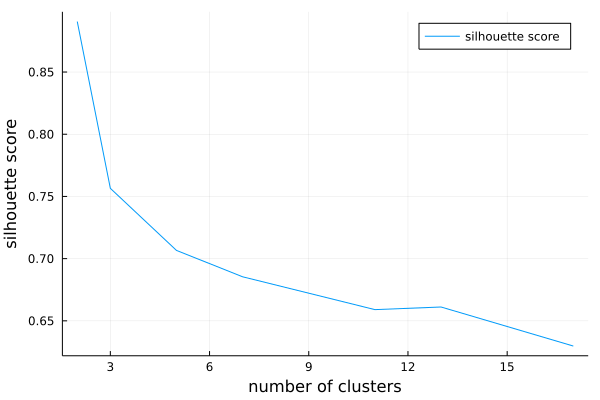

In [234]:
StatsPlots.plot(ks, ys, label="silhouette score", ylabel = "silhouette score", xlabel = "number of clusters")

In [235]:
ymax, ymax_index = findmax(ys);

In [236]:
optimal_k = ks[ymax_index];

In [237]:
clusterings = [Clustering.kmedoids(distance_matrix, optimal_k) for i in 1:10]
max_value, max_value_index = findmax(clustering -> Statistics.mean(Clustering.silhouettes(clustering, distance_matrix)), clusterings);

In [238]:
optimal_clustering = clusterings[max_value_index]

Clustering.KmedoidsResult{Float64}([124, 48], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [5.584962500721156, 4.584962500721156, 4.0, 3.584962500721156, 3.263034405833794, 3.0, 2.777607578663552, 2.584962500721156, 2.415037499278844, 2.263034405833794  …  0.004471495847075957, 0.0049497637251150195, 0.005587207694786045, 0.006383616790854418, 0.007497851445039672, 0.008134170802973628, 0.008611226208000033, 0.009882603281591074, 0.010200272564144797, 0.012263419665828224], [58, 95], 93.82451364485556, 1, true)

In [239]:
min_medoid_value, min_medoid_index = findmin(optimal_clustering.medoids)

(48, 2)

In [240]:
indices_to_include = map(assignment -> assignment .!= min_medoid_index, optimal_clustering.assignments);

In [241]:
threshold = Int(ceil(2^maximum(kmer_depth_of_coverage_bins[.!indices_to_include]))) + 1

119

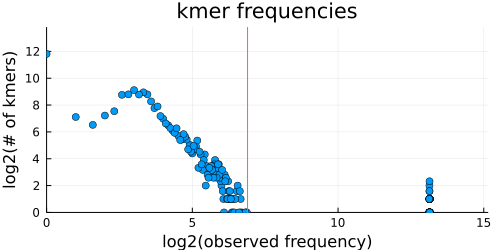

In [242]:
scale = 250
p = Mycelia.plot_kmer_frequency_spectra(values(kmer_counts), log_scale = log2, size=(2scale,scale), title="kmer frequencies")
StatsPlots.vline!(p, log2.([threshold]))

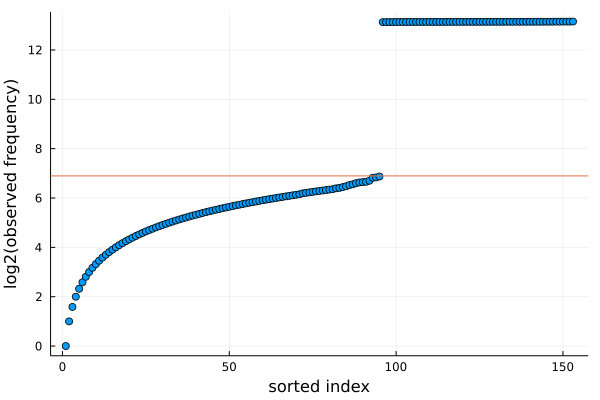

In [243]:
p = StatsPlots.scatter(log2.(first.(kmer_counts_histogram)), legend=false, xlabel = "sorted index", ylabel="log2(observed frequency)")
StatsPlots.hline!(p, log2.([threshold]))

In [244]:
# make me faster by counting edges ahead of time
@time observation_graph = Mycelia.fastx_to_simple_kmer_graph(BioSequences.DNAMer{k}, observations_file, minimum_coverage=threshold)

┌ Info: counting kmers
└ @ Mycelia /home/jovyan/git/Mycelia/src/Mycelia.jl:2999
┌ Info: setting metadata on vertices
└ @ Mycelia /home/jovyan/git/Mycelia/src/Mycelia.jl:3009
┌ Info: loading fastx files into graph
└ @ Mycelia /home/jovyan/git/Mycelia/src/Mycelia.jl:3018
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


  4.677011 seconds (21.89 M allocations: 2.167 GiB, 20.67% gc time)


{90, 178} directed Int64 metagraph with Float64 weights defined by :weight (default weight 1.0)

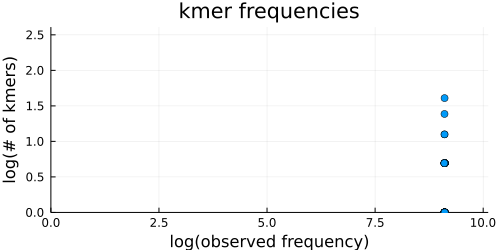

In [245]:
kmer_counts = DataStructures.SortedDict(observation_graph.vprops[v][:kmer] => observation_graph.vprops[v][:weight] for v in Graphs.vertices(observation_graph))
total_observed_kmers = sum(values(kmer_counts))
kmer_probabilities = Dict(k => v/total_observed_kmers for (k,v) in kmer_counts)
scale = 250
Mycelia.plot_kmer_frequency_spectra(values(kmer_counts), size=(2scale,scale), title="kmer frequencies")

In [246]:
reference_kmers = keys(Mycelia.count_canonical_kmers(BioSequences.DNAMer{k}, reference_fasta_file))
distance_to_reference_graph = 1 - LSHFunctions.jaccard(Set(reference_kmers), Set(keys(kmer_counts)))

0.0

In [247]:
kmer_counts_histogram = sort(collect(StatsBase.countmap(collect(values(kmer_counts)))), by=x->x[1])

58-element Vector{Pair{Any, Int64}}:
 8945 => 1
 8955 => 1
 8967 => 2
 8970 => 2
 8973 => 1
 8986 => 2
 8987 => 1
 8989 => 1
 8991 => 1
 8992 => 2
 8993 => 1
 8994 => 1
 8996 => 1
      ⋮
 9044 => 1
 9045 => 2
 9048 => 1
 9051 => 1
 9055 => 1
 9060 => 2
 9067 => 1
 9071 => 1
 9074 => 2
 9082 => 2
 9084 => 1
 9097 => 1

In [248]:
# visualize
gfa_file = observations_file * ".k-$k.gfa"
Mycelia.graph_to_gfa(observation_graph, gfa_file)

run(`$(BANDAGE) image $(gfa_file) $(gfa_file).svg --depwidth .9 --deppower .9`)
# --nodewidth <float> Average node width (0.5 to 1000, default: 5)
# --depwidth <float>  Depth effect on width (0 to 1, default: 0.5)
# --deppower <float>  Power of depth effect on width (0 to 1, default: 0.5)

html_path_to_svg = "./" * repeat("../", length(split(pwd(), '/')) - 3)
html_path_to_svg *= replace("$(gfa_file).svg", "$(homedir())/" => "")

x = "<img src=$(html_path_to_svg)>"
display("text/html", x)
# display("image/svg+xml", read("$(gfa_file).svg", String))

# take in a read

In [249]:
observation = first(observations)

FASTX.FASTQ.Record:
   identifier: 17931635951973638355-oJe5GcXKGh0053VCqlyPeX3Ose23eP48
  description: 3157291459485254640
     sequence: TTATACCGGCCGACGGGTGGTATTCGAGAAGATAGTACAATCTTATGTTGAGCTGCGGTCCACTTGTAGGTGAGGCTCTGGTCTGAGGCGCTTTGCAGTGAG
      quality: UInt8[0x3c, 0x3c, 0x3c, 0x3c, 0x3c, 0x3c, 0x3c, 0x3c, 0x3c, 0x3c  …  0x3c, 0x3c, 0x3c, 0x3c, 0x3c, 0x3c, 0x3c, 0x3c, 0x3c, 0x3c]

# convert it to mers

In [250]:
sequence_mer_iterator = BioSequences.each(BioSequences.BigDNAMer{k}, FASTX.sequence(observation))

BioSequences.EveryMerIterator{BioSequences.BigDNAMer{11}, BioSequences.LongDNASeq}(TTATACCGGCCGACGGGTGGTATTCGAGAAGATAGTACA…TTGTAGGTGAGGCTCTGGTCTGAGGCGCTTTGCAGTGAG, 1, 102)

# find all solid kmers in the read

In [251]:
kmers = collect(keys(kmer_counts))
@assert issorted(kmers)
mer_is_solid = map(mer -> !isempty(searchsorted(kmers, BioSequences.canonical(mer.fw))), sequence_mer_iterator)
count(mer_is_solid)/length(mer_is_solid)

0.6521739130434783

# fill in the gaps

In [257]:
mers = collect(sequence_mer_iterator)

92-element Vector{BioSequences.MerIterResult{BioSequences.BigDNAMer{11}}}:
 BioSequences.MerIterResult{BioSequences.BigDNAMer{11}}(1, TTATACCGGCC, GGCCGGTATAA)
 BioSequences.MerIterResult{BioSequences.BigDNAMer{11}}(2, TATACCGGCCG, CGGCCGGTATA)
 BioSequences.MerIterResult{BioSequences.BigDNAMer{11}}(3, ATACCGGCCGA, TCGGCCGGTAT)
 BioSequences.MerIterResult{BioSequences.BigDNAMer{11}}(4, TACCGGCCGAC, GTCGGCCGGTA)
 BioSequences.MerIterResult{BioSequences.BigDNAMer{11}}(5, ACCGGCCGACG, CGTCGGCCGGT)
 BioSequences.MerIterResult{BioSequences.BigDNAMer{11}}(6, CCGGCCGACGG, CCGTCGGCCGG)
 BioSequences.MerIterResult{BioSequences.BigDNAMer{11}}(7, CGGCCGACGGG, CCCGTCGGCCG)
 BioSequences.MerIterResult{BioSequences.BigDNAMer{11}}(8, GGCCGACGGGT, ACCCGTCGGCC)
 BioSequences.MerIterResult{BioSequences.BigDNAMer{11}}(9, GCCGACGGGTG, CACCCGTCGGC)
 BioSequences.MerIterResult{BioSequences.BigDNAMer{11}}(10, CCGACGGGTGG, CCACCCGTCGG)
 BioSequences.MerIterResult{BioSequences.BigDNAMer{11}}(11, CGACGGGTGGT, A

In [258]:
starting_node = findnext(.!mer_is_solid, 1) - 1
if starting_node <= 1
    @error "need to implement random backward walk"
else
    current_sequence = map(mer -> mer_to_vertex_and_orientation(kmers, mer), mers[1:starting_node-1])
end

5-element Vector{NamedTuple{(:vertex, :orientation), Tuple{Int64, Bool}}}:
 (vertex = 84, orientation = 0)
 (vertex = 61, orientation = 0)
 (vertex = 33, orientation = 1)
 (vertex = 89, orientation = 0)
 (vertex = 13, orientation = 1)

In [259]:
ending_node = findnext(mer_is_solid, starting_node + 2)

18

In [263]:
function walk_the_nodes(graph, a, b)
    kmers = collect(graph.vprops[v][:kmer] for v in Graphs.vertices(graph))
    start_mer = mer_to_vertex_and_orientation(kmers, mers[a])
    stop_mer = mer_to_vertex_and_orientation(kmers, mers[b])
#     shortest_path = Graphs.a_star(observation_graph, start_mer.vertex, stop_mer.vertex)
    V = Graphs.nv(observation_graph)
    return shortest_paths = Graphs.yen_k_shortest_paths(observation_graph, start_mer.vertex, stop_mer.vertex, ones(V, V), 5)
    @show shortest_paths
    shortest_path = first(shortest_paths)
    mer_walk = [start_mer]
    for step in shortest_path
        push!(mer_walk, take_a_step(last(mer_walk), step))
    end
    @assert last(mer_walk) == stop_mer
    return mer_walk
end

walk_the_nodes (generic function with 1 method)

In [264]:
(starting_node == nothing) || (ending_node == nothing) && @error "all done"
mer_walk = walk_the_nodes(observation_graph, starting_node, ending_node)
# append!(current_sequence, mer_walk)
# starting_node = findnext(.!mer_is_solid, length(current_sequence))
# if starting_node != nothing
#     starting_node -= 1
#     solid_stretch = map(mer -> mer_to_vertex_and_orientation(kmers, mer), mers[length(current_sequence):starting_node-1])
#     append!(current_sequence, solid_stretch)
#     ending_node = findnext(mer_is_solid, starting_node + 2)
# end
# if (starting_node == nothing) || (ending_node == nothing)
#     println("break!!")
# end

Graphs.YenState{Float64, Int64}([12.0], [[54, 60, 24, 46, 51, 11, 78, 15, 6, 76, 56, 70, 67]])

In [268]:
mer_to_vertex_and_orientation(kmers, mers[starting_node])

(vertex = 54, orientation = true)

In [269]:
mer_to_vertex_and_orientation(kmers, mers[ending_node])

(vertex = 67, orientation = false)

In [270]:
mer_walk.paths

1-element Vector{Vector{Int64}}:
 [54, 60, 24, 46, 51, 11, 78, 15, 6, 76, 56, 70, 67]

In [208]:
(starting_node == nothing) || (ending_node == nothing) && @error "all done"
mer_walk = walk_the_nodes(observation_graph, starting_node, ending_node)
append!(current_sequence, mer_walk)
starting_node = findnext(.!mer_is_solid, length(current_sequence))
if starting_node != nothing
    starting_node -= 1
    solid_stretch = map(mer -> mer_to_vertex_and_orientation(kmers, mer), mers[length(current_sequence):starting_node-1])
    append!(current_sequence, solid_stretch)
    ending_node = findnext(mer_is_solid, starting_node + 2)
end
if (starting_node == nothing) || (ending_node == nothing)
    println("break!!")
end

In [209]:
(starting_node == nothing) || (ending_node == nothing) && @error "all done"
mer_walk = walk_the_nodes(observation_graph, starting_node, ending_node)
append!(current_sequence, mer_walk)
starting_node = findnext(.!mer_is_solid, length(current_sequence))
if starting_node != nothing
    starting_node -= 1
    solid_stretch = map(mer -> mer_to_vertex_and_orientation(kmers, mer), mers[length(current_sequence):starting_node-1])
    append!(current_sequence, solid_stretch)
    ending_node = findnext(mer_is_solid, starting_node + 2)
end
if (starting_node == nothing) || (ending_node == nothing)
    println("break!!")
end

break!!


In [210]:
observed_oriented_vertices = map(mer -> try mer_to_vertex_and_orientation(kmers, mer) catch nothing end, mers)

92-element Vector{Union{Nothing, NamedTuple{(:vertex, :orientation), Tuple{Int64, Bool}}}}:
 (vertex = 84, orientation = false)
 (vertex = 61, orientation = false)
 (vertex = 33, orientation = true)
 (vertex = 89, orientation = false)
 (vertex = 13, orientation = true)
 (vertex = 54, orientation = true)
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 ⋮
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 (vertex = 85, orientation = true)
 (vertex = 68, orientation = false)
 (vertex = 17, orientation = false)
 (vertex = 43, orientation = false)
 (vertex = 74, orientation = true)
 (vertex = 66, orientation = false)

In [211]:
append!(current_sequence, observed_oriented_vertices[ending_node+1:end])

92-element Vector{NamedTuple{(:vertex, :orientation), Tuple{Int64, Bool}}}:
 (vertex = 84, orientation = 0)
 (vertex = 61, orientation = 0)
 (vertex = 33, orientation = 1)
 (vertex = 89, orientation = 0)
 (vertex = 13, orientation = 1)
 (vertex = 54, orientation = 1)
 (vertex = 60, orientation = 1)
 (vertex = 24, orientation = 0)
 (vertex = 46, orientation = 0)
 (vertex = 51, orientation = 0)
 (vertex = 11, orientation = 0)
 (vertex = 78, orientation = 1)
 (vertex = 15, orientation = 1)
 ⋮
 (vertex = 82, orientation = 0)
 (vertex = 26, orientation = 0)
 (vertex = 4, orientation = 0)
 (vertex = 1, orientation = 0)
 (vertex = 41, orientation = 0)
 (vertex = 79, orientation = 0)
 (vertex = 85, orientation = 1)
 (vertex = 68, orientation = 0)
 (vertex = 17, orientation = 0)
 (vertex = 43, orientation = 0)
 (vertex = 74, orientation = 1)
 (vertex = 66, orientation = 0)

In [212]:
oriented_mers = []
for oriented_vertex in current_sequence
    kmer = observation_graph.vprops[oriented_vertex.vertex][:kmer]
    if !oriented_vertex.orientation
        kmer = BioSequences.reverse_complement(kmer)
    end
    push!(oriented_mers, kmer)
end
oriented_mers

92-element Vector{Any}:
 TTATACCGGCC
 TATACCGGCCG
 ATACCGGCCGA
 TACCGGCCGAC
 ACCGGCCGACG
 CCGGCCGACGG
 CGGCCGACGGC
 GGCCGACGGCT
 GCCGACGGCTG
 CCGACGGCTGG
 CGACGGCTGGT
 GACGGCTGGTA
 ACGGCTGGTAT
 ⋮
 GGTCTGGGCGC
 GTCTGGGCGCT
 TCTGGGCGCTT
 CTGGGCGCTTT
 TGGGCGCTTTG
 GGGCGCTTTGC
 GGCGCTTTGCA
 GCGCTTTGCAG
 CGCTTTGCAGT
 GCTTTGCAGTG
 CTTTGCAGTGA
 TTTGCAGTGAG

In [213]:
seq = BioSequences.LongDNASeq(first(oriented_mers))

11nt DNA Sequence:
TTATACCGGCC

In [214]:
seq = BioSequences.LongDNASeq(first(oriented_mers))
for dst in oriented_mers
#     @show seq
#     @show dst
    seq_tip = seq[end-length(dst)+2:end]
    dst_tip = BioSequences.LongDNASeq(dst)[1:end-1]
    if seq_tip != dst_tip
        @warn "seq_tip != dst_tip"
        @show seq_tip
        @show dst_tip
    end
    push!(seq, dst[end])
end
@show seq

seq_tip = TATACCGGCC
dst_tip = TTATACCGGC
seq_tip = ATACCGGCCC
dst_tip = TATACCGGCC
seq_tip = TACCGGCCCG
dst_tip = ATACCGGCCG
seq_tip = ACCGGCCCGA
dst_tip = TACCGGCCGA
seq_tip = CCGGCCCGAC
dst_tip = ACCGGCCGAC
seq_tip = CGGCCCGACG
dst_tip = CCGGCCGACG
seq_tip = GGCCCGACGG
dst_tip = CGGCCGACGG
seq_tip = GCCCGACGGC
dst_tip = GGCCGACGGC
seq_tip = CCCGACGGCT
dst_tip = GCCGACGGCT
seq_tip = GGTATTCGAG
dst_tip = TGGTATTCGA
seq_tip = GTATTCGAGG
dst_tip = GGTATTCGAG
seq_tip = TATTCGAGGA
dst_tip = GTATTCGAGA
seq_tip = ATTCGAGGAA
dst_tip = TATTCGAGAA
seq_tip = TTCGAGGAAG
dst_tip = ATTCGAGAAG
seq_tip = TCGAGGAAGA
dst_tip = TTCGAGAAGA
seq_tip = CGAGGAAGAT
dst_tip = TCGAGAAGAT
seq_tip = GAGGAAGATA
dst_tip = CGAGAAGATA
seq_tip = AGGAAGATAG
dst_tip = GAGAAGATAG
seq_tip = GGAAGATAGT
dst_tip = AGAAGATAGT
seq_tip = ATGTTGAGCT
dst_tip = TATGTTGAGC
seq_tip = TGTTGAGCTT
dst_tip = ATGTTGAGCT
seq_tip = GTTGAGCTTG
dst_tip = TGTTGAGCTG
seq_tip = TTGAGCTTGC
dst_tip = GTTGAGCTGC
seq_tip = TGAGCTTGCG
dst_tip = TTG

┌ Warning: seq_tip != dst_tip
└ @ Main In[214]:8
┌ Warning: seq_tip != dst_tip
└ @ Main In[214]:8
┌ Warning: seq_tip != dst_tip
└ @ Main In[214]:8
┌ Warning: seq_tip != dst_tip
└ @ Main In[214]:8
┌ Warning: seq_tip != dst_tip
└ @ Main In[214]:8
┌ Warning: seq_tip != dst_tip
└ @ Main In[214]:8
┌ Warning: seq_tip != dst_tip
└ @ Main In[214]:8
┌ Warning: seq_tip != dst_tip
└ @ Main In[214]:8
┌ Warning: seq_tip != dst_tip
└ @ Main In[214]:8
┌ Warning: seq_tip != dst_tip
└ @ Main In[214]:8
┌ Warning: seq_tip != dst_tip
└ @ Main In[214]:8
┌ Warning: seq_tip != dst_tip
└ @ Main In[214]:8
┌ Warning: seq_tip != dst_tip
└ @ Main In[214]:8
┌ Warning: seq_tip != dst_tip
└ @ Main In[214]:8
┌ Warning: seq_tip != dst_tip
└ @ Main In[214]:8
┌ Warning: seq_tip != dst_tip
└ @ Main In[214]:8
┌ Warning: seq_tip != dst_tip
└ @ Main In[214]:8
┌ Warning: seq_tip != dst_tip
└ @ Main In[214]:8
┌ Warning: seq_tip != dst_tip
└ @ Main In[214]:8
┌ Warning: seq_tip != dst_tip
└ @ Main In[214]:8
┌ Warning: seq_tip !

103nt DNA Sequence:
TTATACCGGCCCGACGGCTGGTATTCGAGGAAGATAGTA…CTTGTAGGTGAGGCTCTGGTCTGGGCGCTTTGCAGTGAG

In [ ]:
Mycelia.oriented_path_to_sequence(observation_graph, current_sequence)